# Microfinance analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from matplotlib import colors
from copy import deepcopy


%matplotlib inline

In [2]:
import pickle

from rashomon import tva
from rashomon import loss
from rashomon import counter
from rashomon import metrics
from rashomon import extract_pools
from rashomon.aggregate import (RAggregate_profile, RAggregate,
    find_profile_lower_bound, find_feasible_combinations, remove_unused_poolings, subset_data,
    find_te_het_partitions, find_feasible_sum_subsets
)
from rashomon.sets import RashomonSet, RashomonProblemCache, RashomonSubproblemCache

%load_ext autoreload
%autoreload 2

## Treatment effects

In [3]:
M = 7
R = np.array([3, 3, 3, 4, 4, 4, 4])

df = pd.read_csv("../Data/banerjee_miracle.csv")
# df["treatment"] = df["treatment"] + 1
# df["hh_edu"] = df["hh_edu"] + 1
# df["hh_gender"] = df["hh_gender"] + 1

cols = df.columns

results_dir = "../Results/harvard_talk_april_11_pickles/Microfinance/"

chosen_covariates_idx = [2, 3, 4, 6, 7, 9, 10]
chosen_covariates = [cols[x] for x in chosen_covariates_idx]
print(f"Covariates used are {chosen_covariates}")

outcome_names = ["Any Loan", "Informal Loan", "Female Biz", "Working Hours", "Durables", "Temptation",
                "Expenditure", "Profit", "Revenue", "Employees", "Girls in School", "Biz Assets"]

profile_labels_on = [
    "None",
    "Reg. Biz",
    "Reg. Debt",
    "Reg. Debt, Reg. Biz",
    "Biz",
    "Biz, Reg. Biz",
    "Biz, Reg. Debt",
    "Biz, Reg. Debt, Reg. Biz",
    "Chld",
    "Chld, Reg. Biz",
    "Chld, Reg. Debt",
    "Chld, Reg. Debt, Reg. Biz",
    "Chld, Biz",
    "Chld, Biz, Reg. Biz",
    "Chld, Biz, Reg. Debt",
    "Chld, Biz, Reg. Debt, Reg. Biz",
]

# profile_labels_on = [x[5:] for x in profile_labels_on]
profile_labels_on = [x.replace(",", " |") for x in profile_labels_on]

suffix_possibilities = [
    "",
    "_trt_edu_gen", "_trt_edu", "_trt_gen", "_trt",
    "_edu_gen", "_edu",
    "_gen"
]

Covariates used are ['treatment', 'hh_edu', 'hh_gender', 'children', 'old_biz', 'area_debt_total_base', 'area_business_total_base']


## Helper functions

In [4]:
def format_data(df, outcome_col_id, chosen_covariates_idx):
    
    outcome_col = cols[outcome_col_id]
    df2 = df.copy()
    df2 = df2.dropna(subset=[outcome_col], axis=0)
    
    Z = df2.to_numpy()
    
    X = Z[:, chosen_covariates_idx]
    y = Z[:, outcome_col_id]
    y = (y - np.min(y)) / (np.max(y) - np.min(y))
    y = y.reshape((-1, 1))

    return X, y


def read_pickle(results_dir, fname):

    outcome_fname = results_dir + fname + ".pkl"
    
    with open(outcome_fname, "rb") as f:
        res_dict = pickle.load(f)

    R_set = res_dict["R_set"]
    R_profiles = res_dict["R_profiles"]
    if len(R_set) > 0:
        print(res_dict["q"], res_dict["reg"])

    return R_set, R_profiles


def get_policy_means(M, R, X, y):
    
    num_profiles = 2**M
    profiles, profile_map = tva.enumerate_profiles(M)
    
    all_policies = tva.enumerate_policies(M, R)
    num_policies = len(all_policies)

    num_data = X.shape[0]

    # print(num_policies)
    
    policies_profiles = {}
    policies_profiles_masked = {}
    policies_ids_profiles = {}
    for k, profile in enumerate(profiles):
    
        policies_temp = [(i, x) for i, x in enumerate(all_policies) if tva.policy_to_profile(x) == profile]
        unzipped_temp = list(zip(*policies_temp))
        policies_ids_k = list(unzipped_temp[0])
        policies_k = list(unzipped_temp[1])
        policies_profiles[k] = deepcopy(policies_k)
        policies_ids_profiles[k] = policies_ids_k
    
        profile_mask = list(map(bool, profile))
    
        # Mask the empty arms
        for idx, pol in enumerate(policies_k):
            policies_k[idx] = tuple([pol[i] for i in range(M) if profile_mask[i]])
        policies_profiles_masked[k] = policies_k

    
    D = np.zeros(shape=y.shape, dtype=np.int64)
    profiles_in_data = []
    for i in range(num_data):
        policy_i = tuple([int(x) for x in X[i, :]])
        policy_idx = [idx for idx in range(num_policies) if all_policies[idx] == policy_i]
        profiles_in_data.append(tva.policy_to_profile(policy_i))
        D[i, 0] = int(policy_idx[0])

    policy_means = loss.compute_policy_means(D, y, num_policies)
    
    policy_means_profiles = {}
    for k, profile in enumerate(profiles):
        D_k, y_k = subset_data(D, y, policies_ids_profiles[k])
    
        if D_k is None:
            policy_means_profiles[k] = None
        else:
            policy_means_k = policy_means[policies_ids_profiles[k], :]
            policy_means_profiles[k] = policy_means_k

    return (policy_means_profiles, policies_profiles_masked,
            policies_profiles, policy_means, policies_ids_profiles)


def find_gender_trt_con_pairs(policies, subset_indices, trt_idx, trt_label, con_label):
    trt_con_pairs = []
    found = []
    for i in range(len(subset_indices)):
        pol_i_idx = subset_indices[i]
        pol_i = policies[pol_i_idx]
        if pol_i_idx in found:
            continue
        found_match = False
        for j in range(i+1, len(subset_indices)):
            pol_j_idx = subset_indices[j]
            pol_j = policies[pol_j_idx]
            if pol_i[trt_idx] == pol_j[trt_idx]:
                continue
            if pol_i[:trt_idx] == pol_j[:trt_idx] and pol_i[(trt_idx+1):] == pol_j[(trt_idx+1):]:
                if pol_i[trt_idx] == con_label and pol_j[trt_idx] == trt_label:
                    found_match = True
                    trt_con_pairs.append([pol_i_idx, pol_j_idx])
                elif pol_i[trt_idx] == trt_label and pol_j[trt_idx] == con_label:
                    found_match = True
                    trt_con_pairs.append([pol_j_idx, pol_i_idx])
                if found_match:
                    found.append(pol_i_idx)
                    found.append(pol_j_idx)
                    break
    return trt_con_pairs

def assign_label(a, bins):
    if a == 0:
        return (len(bins) - 1) // 2
    else:
        return np.digitize(a, bins) - (a > 0)

# infty, 2sd, 0, -2sd, -infty

def get_counts(R_set, R_profiles,
               policies_profiles_masked,
               policies_profiles,
               policies_ids_profiles,
               policy_means,
               R_vals,
               collect_effects=False,
               bins=None
            ):
    
    assert (collect_effects or bins != None)

    n_models = len(R_set)
    
    trt_idx = 0
    trt_label = 1
    con_label = 0
    gen_idx = 2
    mal_label = 1
    fem_label = 0

    if R_vals[0] == 3:
        trt_label += 1
        con_label += 1
    if R_vals[2] == 3:
        mal_label += 1
        fem_label += 1


    M = R_vals.shape[0]
    profiles, profile_map = tva.enumerate_profiles(M)
    all_policies = tva.enumerate_policies(M, R_vals)
    num_policies = len(all_policies)
    
    trt_indices = [idx for idx, p in enumerate(all_policies) if p[trt_idx] == trt_label]
    con_indices = [idx for idx, p in enumerate(all_policies) if p[trt_idx] == con_label]
    mal_indices = [idx for idx, p in enumerate(all_policies) if p[gen_idx] == mal_label]
    fem_indices = [idx for idx, p in enumerate(all_policies) if p[gen_idx] == fem_label]
        
    # Find treatment control pairs for each gender
    # The first element is control and the second element is treatment
    mal_trt_pairs = find_gender_trt_con_pairs(all_policies, mal_indices, trt_idx, trt_label, con_label)
    fem_trt_pairs = find_gender_trt_con_pairs(all_policies, fem_indices, trt_idx, trt_label, con_label)

    # The last four arms are the ones we care about
    active_arms = 4
    active_profiles, _ = tva.enumerate_profiles(active_arms)
    num_active_profiles = len(active_profiles)

    # Profiles with all the features (but not the treatment)
    profiles_x, _ = tva.enumerate_profiles(M-1)

    policies_to_active_profiles = {}
    active_profiles_policies_count = np.zeros(num_active_profiles)
    dosages = R_vals - 1
    fixed_poss = np.prod(dosages[:3])
    for i, active_prof in enumerate(active_profiles):
        prof_np = np.array(active_prof)
        dosages_prof_i = dosages[3:][prof_np > 0]
        num_policies_prof_i = fixed_poss * np.prod(dosages_prof_i)
        active_profiles_policies_count[i] = num_policies_prof_i
    
    active_profiles_policies_count_pooled = active_profiles_policies_count.copy()
    active_profiles_policies_count_gender = active_profiles_policies_count.copy()
    # print(R_vals)

    if R_vals[0] == 3 and R_vals[1] == 3 and R_vals[2] == 3:
        active_profiles_policies_count_pooled /= 2
        active_profiles_policies_count_gender /= 4
    
    elif R_vals[0] == 2 and R_vals[1] == 3 and R_vals[2] == 2:
        active_profiles_policies_count_pooled *= 2

    elif R_vals[0] == 3 and R_vals[1] == 3 and R_vals[2] == 2:
        active_profiles_policies_count_gender /= 2

    elif R_vals[0] == 2 and R_vals[1] == 2 and R_vals[2] == 2:
        active_profiles_policies_count_pooled[0] *= 4
        active_profiles_policies_count_pooled[1:] *= 4
        active_profiles_policies_count_gender[0] *= 2
        active_profiles_policies_count_gender[1:] *= 2
        
    elif R_vals[0] == 2 and R_vals[1] == 2 and R_vals[2] == 3:
        active_profiles_policies_count_pooled *= 2
        
    elif R_vals[0] == 3 and R_vals[1] == 2 and R_vals[2] == 2:
        active_profiles_policies_count_pooled *= 2
        
    elif R_vals[0] == 3 and R_vals[1] == 2 and R_vals[2] == 3:
        active_profiles_policies_count_gender /= 2
        
    elif R_vals[0] == 2 and R_vals[1] == 3 and R_vals[2] == 3:
        active_profiles_policies_count_gender /= 2

    for i, pol in enumerate(all_policies):
        last_four_arms = pol[3:]
        for j, prof in enumerate(active_profiles):
            if tva.policy_to_profile(last_four_arms) == prof:
                policies_to_active_profiles[i] = j

    total_ctr = n_models

    if bins != None:
        trt_eff_bins = np.zeros(shape=(num_active_profiles, len(bins['trt'])))
        gen_eff_bins = np.zeros(shape=(num_active_profiles, len(bins['gender'])))

    # print("Beta size", num_policies, R_vals)
    beta = np.zeros(shape=(num_policies,))
    norm_const = 0
    total_prob = 0

    hasse_edges = {}
    for k, profile in enumerate(profiles):
        policies_k = [x for x in all_policies if tva.policy_to_profile(x) == profile]
        hasse_edges[k] = extract_pools.lattice_edges(policies_k)

    if collect_effects:
        gen_trt_eff_array = []
        trt_eff_array = []
    
    for r, model_r in enumerate(R_set):
        pi_policies_profiles_r = {}
        loss_r = 0

        for k, profile_idx in enumerate(model_r):

            trt_profile_k = tuple([1] + list(profiles_x[k]))
            trt_profile_k_idx = profile_map[trt_profile_k]
            trt_policies_k = policies_profiles_masked[trt_profile_k_idx]
            trt_policies_k_ids = policies_ids_profiles[trt_profile_k_idx]
            
            ctl_profile_k = tuple([0] + list(profiles_x[k]))
            ctl_profile_k_idx = profile_map[ctl_profile_k]
            ctl_policies_k = policies_profiles_masked[ctl_profile_k_idx]
            ctl_policies_k_ids = policies_ids_profiles[ctl_profile_k_idx]

            sigma_int_k = R_profiles[k][profile_idx][0]
            sigma_trt_k = R_profiles[k][profile_idx][2]
            sigma_ctl_k = R_profiles[k][profile_idx][3]
            
            loss_r += R_profiles[k][profile_idx][1]

            # If both are None, then there is no data for either profile
            if sigma_trt_k is None and sigma_ctl_k is None:
                continue
                
            # If just one is None, then there is no data for that profile
            # So we cannot compute the TE
            if sigma_trt_k is None:
                ctl_pools_k_0, _ = extract_pools.extract_pools(ctl_policies_k, sigma_ctl_k, hasse_edges[ctl_profile_k_idx])
                ctl_pools_k = tva.profile_ids_to_univ_ids(ctl_pools_k_0, ctl_policies_k_ids)
                sigma_policies_k = {}
                for pi, pol_pi_list in ctl_pools_k.items():
                    for pol_pi_i in pol_pi_list:
                        sigma_policies_k[pol_pi_i] = pi

            elif sigma_ctl_k is None:
                trt_pools_k_0, _ = extract_pools.extract_pools(trt_policies_k, sigma_trt_k, hasse_edges[trt_profile_k_idx])
                trt_pools_k = tva.profile_ids_to_univ_ids(trt_pools_k_0, trt_policies_k_ids)
                sigma_policies_k = {}
                for pi, pol_pi_list in trt_pools_k.items():
                    for pol_pi_i in pol_pi_list:
                        sigma_policies_k[pol_pi_i] = pi
                        
            else:
                trt_pools_k_0, _ = extract_pools.extract_pools(trt_policies_k, sigma_trt_k, hasse_edges[trt_profile_k_idx])
                ctl_pools_k_0, _ = extract_pools.extract_pools(ctl_policies_k, sigma_ctl_k, hasse_edges[ctl_profile_k_idx])
                
                trt_pools_k = tva.profile_ids_to_univ_ids(trt_pools_k_0, trt_policies_k_ids)
                ctl_pools_k = tva.profile_ids_to_univ_ids(ctl_pools_k_0, ctl_policies_k_ids)
    
                sigma_pools_k, sigma_policies_k = extract_pools.get_trt_ctl_pooled_partition(
                            trt_pools_k, ctl_pools_k, sigma_int_k
                        )
            
            pi_policies_profiles_r[k] = sigma_policies_k
        
        prob_r = np.exp(-loss_r)
        total_prob += prob_r
        
        # Aggregate pools
        pi_pools_r, pi_policies_r = extract_pools.__aggregate_pools__(pi_policies_profiles_r)
        mu_pools_r = loss.compute_pool_means(policy_means, pi_pools_r)
        
        policies_outcomes_est = np.zeros(shape=(num_policies,)) + np.inf
        
        for p, pool_id in pi_policies_r.items():
            policies_outcomes_est[p] = mu_pools_r[pool_id]
            beta[p] += mu_pools_r[pool_id] * np.exp(-loss_r)
        norm_const += np.exp(-loss_r)

        mal_outcome_pairs = np.zeros(shape=(len(mal_trt_pairs), 2))
        fem_outcome_pairs = np.zeros(shape=(len(fem_trt_pairs), 2))
    
        for idx, pair in enumerate(mal_trt_pairs):
            con_pol_idx = pair[0]
            trt_pol_idx = pair[1]
            mal_outcome_pairs[idx, 0] = policies_outcomes_est[con_pol_idx]
            mal_outcome_pairs[idx, 1] = policies_outcomes_est[trt_pol_idx]
                    
        for idx, pair in enumerate(fem_trt_pairs):
            con_pol_idx = pair[0]
            trt_pol_idx = pair[1]
            fem_outcome_pairs[idx, 0] = policies_outcomes_est[con_pol_idx]
            fem_outcome_pairs[idx, 1] = policies_outcomes_est[trt_pol_idx]

        for i in range(len(mal_trt_pairs)):

            if all_policies[mal_trt_pairs[i][0]][3:] != all_policies[mal_trt_pairs[i][1]][3:]:
                raise RuntimeError("Profile indexing does not match for male treatment-control pairs")
            if all_policies[fem_trt_pairs[i][0]][3:] != all_policies[fem_trt_pairs[i][1]][3:]:
                raise RuntimeError("Profile indexing does not match for female treatment-control pairs")
            if all_policies[fem_trt_pairs[i][0]][3:] != all_policies[mal_trt_pairs[i][1]][3:]:
                raise RuntimeError("Profile indexing does not match for male-female treatment-control pairs")
            
            y_mal_con = mal_outcome_pairs[i, 0]
            y_mal_trt = mal_outcome_pairs[i, 1]
            y_fem_con = fem_outcome_pairs[i, 0]
            y_fem_trt = fem_outcome_pairs[i, 1]

            if np.isinf(y_mal_con) and np.isinf(y_fem_con) and np.isinf(y_mal_trt) and np.isinf(y_fem_trt):
                continue

            # Find the profile
            mal_con_pol_idx = mal_trt_pairs[i][0]
            profile_i = policies_to_active_profiles[mal_con_pol_idx]

            # Compute effects and then count them
            if np.isinf(y_mal_con) or np.isinf(y_mal_trt):
                trt_eff_mal = 0
            else:
                trt_eff_mal = y_mal_trt - y_mal_con
            if np.isinf(y_fem_trt) or np.isinf(y_fem_con):
                trt_eff_fem = 0
            else:
                trt_eff_fem = y_fem_trt - y_fem_con
            gen_trt_eff = trt_eff_fem - trt_eff_mal

            if collect_effects:
                trt_eff_array += [trt_eff_mal, trt_eff_fem]
                gen_trt_eff_array += [gen_trt_eff]
                
            else:
                '''vec = np.array(cov_counts_r)
                counts_vec = np.array([assign_label(vec[i], bins) for i in range(len(vec))])
                counts_vec = np.array([np.dot(np.where(counts_vec == i, 1, 0), all_model_prob_counts[covariate_idx][race_idx][idx]) for i in range(len(bins))])
                counts_vec /= np.sum(counts_vec)
                signed_counts_race.append(counts_vec.copy())'''

                # Treatment effects for male
                trt_label_mal = assign_label(trt_eff_mal, bins["trt"])
                trt_eff_bins[profile_i, trt_label_mal] += prob_r

                trt_label_fem = assign_label(trt_eff_fem, bins["trt"])
                trt_eff_bins[profile_i, trt_label_fem] += prob_r

                # Treatment effects crossed with gender
                gen_label = assign_label(gen_trt_eff, bins["gender"])
                gen_eff_bins[profile_i, gen_label] += prob_r
        # break

    # print(active_profiles_policies_count)
    # print(active_profiles_policies_count_pooled)
    # print(active_profiles_policies_count_gender)
    
    # Normalize results
    # print("pooled", pos_eff_ctr + zero_eff_ctr + neg_eff_ctr)
    if collect_effects:
        results = {
            "gender_effects": gen_trt_eff_array,
            "treatment_effects": trt_eff_array,
            "total_prob": total_prob
        }
    else:
        active_profiles_policies_count_pooled = active_profiles_policies_count_pooled.reshape((-1, 1))
        active_profiles_policies_count_gender = active_profiles_policies_count_gender.reshape((-1, 1))
        trt_eff_bins /= active_profiles_policies_count_pooled
        gen_eff_bins /= active_profiles_policies_count_gender

        beta /= norm_const

        results = {
            "lowest_pooled": trt_eff_bins[:, 4],
            "low_pooled": trt_eff_bins[:, 3],
            "0_pooled": trt_eff_bins[:, 2],
            "high_pooled": trt_eff_bins[:, 1],
            "highest_pooled": trt_eff_bins[:, 0],
            "lowest_gender": gen_eff_bins[:, 4],
            "low_gender": gen_eff_bins[:, 3],
            "0_gender": gen_eff_bins[:, 2],
            "high_gender": gen_eff_bins[:, 1],
            "highest_gender": gen_eff_bins[:, 0],
            "n_models": total_ctr,
            "beta": beta
        }

    return results

In [5]:
map_arm1 = {-1: "undef", 0: "ctl", 1: "trt"}
map_arm2 = {-1: "undef", 0: "hh_not_edu", 1: "hh_edu"}
map_arm3 = {-1: "undef", 0: "hh_female", 1: "hh_male"}
map_arm4 = {0: "no kids", 1: "1 kid", 2: "2 kids", 3: "> 2 kids"}
map_arm5 = {0: "no biz", 1: "1-2 biz", 2: "3-5 biz", 3: "> 5 biz"}
map_arm6 = {0: "debt_q1", 1: "debt_q2", 2: "debt_q3", 3: "debt_q4"}
map_arm7 = {0: "biz_q1", 1: "biz_q2", 2: "biz_q3", 3: "biz_q4"}

maps = [
    map_arm1,
    map_arm2,
    map_arm3,
    map_arm4,
    map_arm5,
    map_arm6,
    map_arm7,
]

### HERE

In [6]:
# Calculating Standard Deviations, Creating Bins, and calculating Model Probabilities

all_details = {}

lambda_str = "_1.50e-06"
# lambda_str = ""

for outcome_col_id in range(14, 26):
     outcome_col = cols[outcome_col_id]
     outcome_title = outcome_names[outcome_col_id-14]
    
     results_subdir = results_dir + outcome_col + "/"
     # results_subdir = results_dir + "_archive_lambda_1e-6/" + outcome_col + "/"
     pkl_prefix = results_subdir + outcome_col + lambda_str
    
     num_active_arms = 4
     num_active_profiles = 2**num_active_arms

     print(f"Outcome is {outcome_col}")

     for suffix in suffix_possibilities:

         # if suffix != "_trt_gen":
         #     continue

         this_df = df.copy()
         this_R = np.array([2, 2, 2, 4, 4, 4, 4])
         if "trt" not in suffix:
             this_df["treatment"] = this_df["treatment"] + 1
             this_R[0] += 1
         if "edu" not in suffix:
             this_df["hh_edu"] = this_df["hh_edu"] + 1
             this_R[1] += 1
         if "gen" not in suffix:
             this_df["hh_gender"] = this_df["hh_gender"] + 1
             this_R[2] += 1

         # R_set, R_profiles = read_pickle(results_subdir, outcome_col + suffix + "_pruned")
         # R_set, R_profiles = read_pickle(results_subdir, outcome_col + suffix + "_te")
         R_set, R_profiles = read_pickle(results_subdir, outcome_col + suffix + lambda_str + "_pruned_te")

         if len(R_set) == 0:
             print(f"\tSuffix {suffix} has no models")
             continue
         print(f"\tWorking on suffix {suffix} - {len(R_set)} models")
        

         all_policies = tva.enumerate_policies(M, this_R)
         policies_str = []
         for pol in all_policies:
             polx = list(pol)
             pol_str = ""
             for m in range(M):
                 if this_R[m] == 3:
                     polx[m] = pol[m] - 1
                 pol_str += maps[m][polx[m]] + ","
             policies_str.append(pol_str)
         print("Num policies", len(policies_str))

         X, y = format_data(this_df, outcome_col_id, chosen_covariates_idx)
        
         # num_data = X.shape[0]
         # print(f"There are {num_data} data points")
        
         pol_res = get_policy_means(M, this_R, X, y)
         policy_means_profiles = pol_res[0]
         policies_profiles_masked = pol_res[1]
         policies_profiles = pol_res[2]
         policies_means = pol_res[3]
         policies_ids_profiles = pol_res[4]
        
         effects = get_counts(R_set, R_profiles,
                              policies_profiles_masked,
                              policies_profiles,
                              policies_ids_profiles,
                              policies_means,
                              this_R,
                              collect_effects=True
                             )
         
         total_prob = effects['total_prob']
         trt_eff_std = np.std(effects['treatment_effects'])
         gen_eff_std = np.std(effects['gender_effects'])
         trt_eff_std_min = np.min(effects['treatment_effects'])
         gen_eff_std_min = np.min(effects['gender_effects'])
         trt_eff_std_max = np.max(effects['treatment_effects'])
         gen_eff_std_max = np.max(effects['gender_effects'])
     # break

     all_details[outcome_col] = {
         "gender_std": gen_eff_std,
         "treatment_std": trt_eff_std,
         "max_treatment": trt_eff_std_max,
         "max_gender": gen_eff_std_max,
         "min_treatment": trt_eff_std_min,
         "min_gender": gen_eff_std_min,
         "total_prob": total_prob
     }

bins = {}
for outcome, std_dict in all_details.items():
    bin_trt = [std_dict['min_treatment'] - 1] + [2 * std_dict['treatment_std'] * i for i in range(-1, 2)] + [std_dict['max_treatment'] + 1]
    bin_gender = [std_dict['min_gender'] - 1] + [2 * std_dict['gender_std'] * i for i in range(-1, 2)] + [std_dict['max_gender'] + 1]
    bin_dict = {
        "trt": bin_trt[::-1],
        "gender": bin_gender[::-1]
    }
    bins[outcome] = bin_dict

Outcome is anyloan_amt_2
	Suffix  has no models
	Suffix _trt_edu_gen has no models
	Suffix _trt_edu has no models
	Suffix _trt_gen has no models
0.0034573913584112093 1.5e-06
	Working on suffix _trt - 466 models
Num policies 4608
	Suffix _edu_gen has no models
	Suffix _edu has no models
	Suffix _gen has no models
Outcome is informal_amt_2
	Suffix  has no models
	Suffix _trt_edu_gen has no models
	Suffix _trt_edu has no models
	Suffix _trt_gen has no models
0.0023231769964495315 1.5e-06
	Working on suffix _trt - 244 models
Num policies 4608
	Suffix _edu_gen has no models
	Suffix _edu has no models
	Suffix _gen has no models
Outcome is female_biz_pct_2
	Suffix  has no models
0.1480008 1.5e-06
	Working on suffix _trt_edu_gen - 512 models
Num policies 2048
	Suffix _trt_edu has no models
	Suffix _trt_gen has no models
	Suffix _trt has no models
	Suffix _edu_gen has no models
	Suffix _edu has no models
	Suffix _gen has no models
Outcome is hours_week_2
	Suffix  has no models
0.00648402985579

In [7]:
all_results = {}

lambda_str = "_1.50e-06"
# lambda_str = ""

for outcome_col_id in range(14, 26):
     outcome_col = cols[outcome_col_id]
     outcome_title = outcome_names[outcome_col_id-14]
    
     results_subdir = results_dir + outcome_col + "/"
     # results_subdir = results_dir + "_archive_lambda_1e-6/" + outcome_col + "/"
     pkl_prefix = results_subdir + outcome_col
    
     num_active_arms = 4
     num_active_profiles = 2**num_active_arms
    
     lowest_eff_ctr = np.zeros(num_active_profiles)
     low_eff_ctr = np.zeros(num_active_profiles)
     zero_eff_ctr = np.zeros(num_active_profiles)
     high_eff_ctr = np.zeros(num_active_profiles)
     highest_eff_ctr = np.zeros(num_active_profiles)
     lowest_eff_gender_ctr = np.zeros(num_active_profiles)
     low_eff_gender_ctr = np.zeros(num_active_profiles)
     zero_eff_gender_ctr = np.zeros(num_active_profiles)
     high_eff_gender_ctr = np.zeros(num_active_profiles)
     highest_eff_gender_ctr = np.zeros(num_active_profiles)
     total_ctr = 0

     print(f"Outcome is {outcome_col}")

     for suffix in suffix_possibilities:

         # if suffix != "_trt_gen":
         #     continue

         this_df = df.copy()
         this_R = np.array([2, 2, 2, 4, 4, 4, 4])
         if "trt" not in suffix:
             this_df["treatment"] = this_df["treatment"] + 1
             this_R[0] += 1
         if "edu" not in suffix:
             this_df["hh_edu"] = this_df["hh_edu"] + 1
             this_R[1] += 1
         if "gen" not in suffix:
             this_df["hh_gender"] = this_df["hh_gender"] + 1
             this_R[2] += 1

         # R_set, R_profiles = read_pickle(results_subdir, outcome_col + suffix + "_pruned")
         # R_set, R_profiles = read_pickle(results_subdir, outcome_col + suffix + "_te")
         R_set, R_profiles = read_pickle(results_subdir, outcome_col + suffix + lambda_str + "_pruned_te")

         if len(R_set) == 0:
             print(f"\tSuffix {suffix} has no models")
             continue
         print(f"\tWorking on suffix {suffix} - {len(R_set)} models")
        

         all_policies = tva.enumerate_policies(M, this_R)
         policies_str = []
         for pol in all_policies:
             polx = list(pol)
             pol_str = ""
             for m in range(M):
                 if this_R[m] == 3:
                     polx[m] = pol[m] - 1
                 pol_str += maps[m][polx[m]] + ","
             policies_str.append(pol_str)
         print("Num policies", len(policies_str))

         X, y = format_data(this_df, outcome_col_id, chosen_covariates_idx)
        
         # num_data = X.shape[0]
         # print(f"There are {num_data} data points")
        
         pol_res = get_policy_means(M, this_R, X, y)
         policy_means_profiles = pol_res[0]
         policies_profiles_masked = pol_res[1]
         policies_profiles = pol_res[2]
         policies_means = pol_res[3]
         policies_ids_profiles = pol_res[4]

        
         ctr_res = get_counts(R_set, R_profiles,
                              policies_profiles_masked,
                              policies_profiles,
                              policies_ids_profiles,
                              policies_means,
                              this_R,
                              bins=bins[outcome_col]
                             )

         lowest_eff_ctr += ctr_res["lowest_pooled"]
         low_eff_ctr += ctr_res["low_pooled"]
         zero_eff_ctr += ctr_res["0_pooled"]
         high_eff_ctr += ctr_res["high_pooled"]
         highest_eff_ctr += ctr_res["highest_pooled"]
         lowest_eff_gender_ctr += ctr_res["lowest_gender"]
         low_eff_gender_ctr += ctr_res["low_gender"]
         zero_eff_gender_ctr += ctr_res["0_gender"]
         high_eff_gender_ctr += ctr_res["high_gender"]
         highest_eff_gender_ctr += ctr_res["highest_gender"]
         total_ctr += ctr_res["n_models"]
         beta = ctr_res["beta"]

     # break

     all_results[outcome_col] = {
            "lowest_pooled": lowest_eff_ctr,
            "low_pooled": low_eff_ctr,
            "0_pooled": zero_eff_ctr,
            "high_pooled": high_eff_ctr,
            "highest_pooled": highest_eff_ctr,
            "lowest_gender": lowest_eff_gender_ctr,
            "low_gender": low_eff_gender_ctr,
            "0_gender": zero_eff_gender_ctr,
            "high_gender": high_eff_gender_ctr,
            "highest_gender": highest_eff_gender_ctr,
            "n_models": total_ctr,
            "policies": policies_str,
            "beta": beta
        }


Outcome is anyloan_amt_2
	Suffix  has no models
	Suffix _trt_edu_gen has no models
	Suffix _trt_edu has no models
	Suffix _trt_gen has no models
0.0034573913584112093 1.5e-06
	Working on suffix _trt - 466 models
Num policies 4608
	Suffix _edu_gen has no models
	Suffix _edu has no models
	Suffix _gen has no models
Outcome is informal_amt_2
	Suffix  has no models
	Suffix _trt_edu_gen has no models
	Suffix _trt_edu has no models
	Suffix _trt_gen has no models
0.0023231769964495315 1.5e-06
	Working on suffix _trt - 244 models
Num policies 4608
	Suffix _edu_gen has no models
	Suffix _edu has no models
	Suffix _gen has no models
Outcome is female_biz_pct_2
	Suffix  has no models
0.1480008 1.5e-06
	Working on suffix _trt_edu_gen - 512 models
Num policies 2048
	Suffix _trt_edu has no models
	Suffix _trt_gen has no models
	Suffix _trt has no models
	Suffix _edu_gen has no models
	Suffix _edu has no models
	Suffix _gen has no models
Outcome is hours_week_2
	Suffix  has no models
0.00648402985579

In [ ]:
# for k, v in all_results.items():
#     new_policies = []
#     new_beta = []
#     for idx, pol in enumerate(v["policies"]):
#         if "undef" not in pol:
#             new_policies.append(pol)
#             new_beta.append(v["beta"][idx])
#     all_results[k]["policies"] = new_policies
#     all_results[k]["beta"] = new_beta

In [70]:
lambda_str = "_1.50e-06"

counter_fname = f"../Results/microfinance/counter_results{lambda_str}_2.pkl"

with open(counter_fname, "wb") as f:
    pickle.dump(all_results, f, pickle.HIGHEST_PROTOCOL)

#with open(counter_fname, "rb") as f:
#    all_results = pickle.load(f)

In [71]:
df_dict = {}
for k, v in all_results.items():
    for pol, beta_i in zip(v["policies"], v["beta"]):
        if pol in df_dict.keys():
            df_dict[pol].append(beta_i)
        else:
            df_dict[pol] = [beta_i]

cols = chosen_covariates + list(all_results.keys())
df_list = []
for k, v in df_dict.items():
    df_list.append(k.split(",")[:-1] + v)

df = pd.DataFrame(df_list, columns=cols)

In [72]:
df.to_csv("../Results/microfinance/outcomes.csv")

In [73]:
ctl_df = df[df["treatment"] == "ctl"].copy().reset_index()
trt_df = df[df["treatment"] == "trt"].copy().reset_index()

In [74]:
for k in all_results.keys():
    trt_df[k] = trt_df[k] - ctl_df[k]

trt_df.to_csv("../Results/microfinance/te.csv")

## Table for identifying patterns

In [99]:
# Outdated; does not split into bins based on standard deviations but only based on sign of effect. Also doesn't scale for model probability.

pooled_counts = []
gender_counts = []

outcome_names = ["Any Loan", "Informal Loan", "Female Business Participation", "Working Hours", "Durables", "Temptation",
                "Expenditure", "Profit", "Revenue", "Employees", "Girls in School", "Business Assets"]

for col_name, counts in all_results.items():

    gender_matrix = np.concatenate((
        counts["+_gender"],
        counts["0_gender"],
        counts["-_gender"]),
        axis=0).reshape((3,-1))
    
    pooled_matrix = np.concatenate((
        counts["+_pooled"],
        counts["0_pooled"],
        counts["-_pooled"]),
        axis=0).reshape((3,-1))

    pooled_matrix = pooled_matrix / counts["n_models"]
    gender_matrix = gender_matrix / counts["n_models"]

    pooled_counts.append(pooled_matrix)
    gender_counts.append(gender_matrix)

# profile_labels_on = [
#     "None",
#     "R. Bus",
#     "R. Debt",
#     "R. Debt, Reg. Bus",
#     "Bus",
#     "Bus, R. Bus",
#     "Bus, R. Debt",
#     "Bus, R. Debt, R. Bus",
#     "Chld",
#     "Chld, R. Bus",
#     "Chld, R. Debt",
#     "Chld, R. Debt, Reg. Bus",
#     "Chld, Bus",
#     "Chld, Bus, R. Bus",
#     "Chld, Bus, R. Debt",
#     "Chld, Bus, R. Debt, R. Bus",
# ]
profile_labels_on = [
    "---- | --- | ------- | ------",
    "---- | --- | ------- | R. Bus",
    "---- | --- | R. Debt | ------",
    "---- | --- | R. Debt | R. Bus",
    "---- | Bus | ------- | ------",
    "---- | Bus | ------- | R. Bus",
    "---- | Bus | R. Debt | ------",
    "---- | Bus | R. Debt | R. Bus",
    "Chld | --- | ------- | ------",
    "Chld | --- | ------- | R. Bus",
    "Chld | --- | R. Debt | ------",
    "Chld | --- | R. Debt | R. Bus",
    "Chld | Bus | ------- | ------",
    "Chld | Bus | ------- | R. Bus",
    "Chld | Bus | R. Debt | ------",
    "Chld | Bus | R. Debt | R. Bus",
]

# profile_labels_on = [x.replace]

KeyError: '+_gender'

In [ ]:
pooled_counts[0].shape

(3, 16)

1. Large households that are novices to business in thin credit and business markets
2. Small previous entrepreneurs in thin credit markets in thick competitive environments
3. And then we have three profiles that are somewhat similar in that they do a very limited job of robust aspects of both household and business behavior.
    - Both novices and entrepreneurs of small households in empty markets
    - Larger households that are novices with no pre-existing credit but in competitive markets

In [ ]:
threshold = 0.8

pos_trt_matrix = []
neg_trt_matrix = []
any_trt_matrix = []
for idx, pooled_matrix in enumerate(pooled_counts):
    pos_idx = pooled_matrix[0, :] > threshold
    pos_trt_matrix.append(pos_idx)
    
    neg_idx = pooled_matrix[2, :] > threshold
    neg_trt_matrix.append(neg_idx)

    any_trt = np.max(pooled_matrix, axis=0)
    # print(any_trt)
    any_idx = any_trt > threshold
    # print(pooled_matrix[[0, 2], :])
    # print(np.max(pooled_matrix[[0, 2], :], axis=0))
    # print("--")
    any_trt_matrix.append(any_idx)
    # break

pos_trt_matrix = np.array(pos_trt_matrix, dtype=np.int64).T
neg_trt_matrix = np.array(neg_trt_matrix, dtype=np.int64).T
any_trt_matrix = np.array(any_trt_matrix, dtype=np.int64).T

# print(pos_trt_matrix)

pos_trt_df = pd.DataFrame(pos_trt_matrix, columns=outcome_names)
pos_trt_df.index = profile_labels_on
pos_trt_df["sum"] = pos_trt_df.sum(axis=1)

neg_trt_df = pd.DataFrame(neg_trt_matrix, columns=outcome_names)
neg_trt_df.index = profile_labels_on
neg_trt_df["sum"] = neg_trt_df.sum(axis=1)

any_trt_df = pd.DataFrame(any_trt_matrix, columns=outcome_names)
any_trt_df.index = profile_labels_on
any_trt_df["loans"] = (any_trt_df["Informal Loan"] + any_trt_df["Any Loan"]) / 2
any_trt_df["hh_behavior"] = (any_trt_df["Durables"] + any_trt_df["Temptation"] + any_trt_df["Working Hours"]) / 3
any_trt_df["biz"] = (any_trt_df["Employees"] + any_trt_df["Profit"] + any_trt_df["Revenue"] + any_trt_df["Business Assets"] + any_trt_df["Female Business Participation"]) / 5
any_trt_df["girls_school"] = any_trt_df["Girls in School"]
any_trt_df = any_trt_df.drop(outcome_names, axis=1)

any_trt_df

,loans,hh_behavior,biz,girls_school
---- | --- | ------- | ------,1.0,0.333333,0.4,0
---- | --- | ------- | R. Bus,0.5,0.000000,0.4,0
---- | --- | R. Debt | ------,0.5,0.333333,0.6,0
---- | --- | R. Debt | R. Bus,0.0,0.333333,0.4,0
---- | Bus | ------- | ------,1.0,0.333333,0.4,0
---- | Bus | ------- | R. Bus,1.0,0.333333,0.6,0
---- | Bus | R. Debt | ------,0.5,0.333333,0.2,0
---- | Bus | R. Debt | R. Bus,0.0,0.333333,0.4,0
Chld | --- | ------- | ------,1.0,0.666667,0.4,0
Chld | --- | ------- | R. Bus,1.0,0.333333,0.4,0


### Single plots

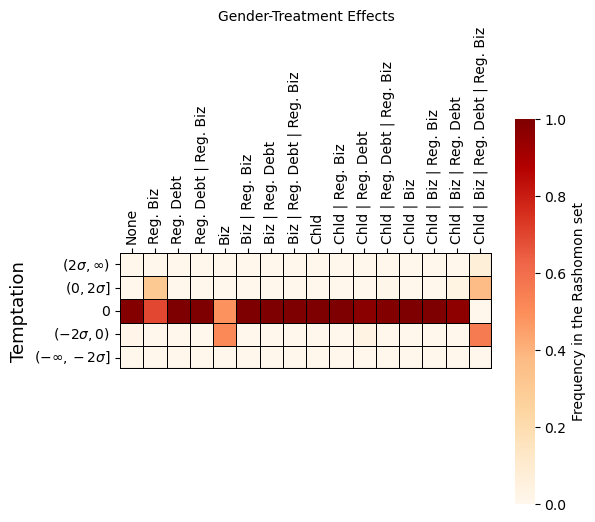

In [8]:
outcome_col_id = 19
outcome_col = cols[outcome_col_id]
outcome_title = outcome_names[outcome_col_id-14]

plot_gender_effects = True

if plot_gender_effects:
    plot_matrix = np.concatenate((
        all_results[outcome_col]["highest_gender"],
        all_results[outcome_col]["high_gender"],
        all_results[outcome_col]["0_gender"],
        all_results[outcome_col]["low_gender"],
        all_results[outcome_col]["lowest_gender"]),
        axis=0).reshape((5,-1))
else:
    plot_matrix = np.concatenate((
        all_results[outcome_col]["highest_pooled"],
        all_results[outcome_col]["high_pooled"],
        all_results[outcome_col]["0_pooled"],
        all_results[outcome_col]["low_pooled"],
        all_results[outcome_col]["lowest_pooled"]),
        axis=0).reshape((5,-1))

plot_matrix = plot_matrix / all_details[outcome_col]["total_prob"] # Divide by normalizing constant (sum of posteriors)

fig, ax = plt.subplots(figsize=(6,5))

res = sns.heatmap(
    plot_matrix,
    cmap="OrRd",
    linewidths=0.5,
    linecolor="black",
    # annot=True,
    square=True,
    #vmin=0,
    #vmax=1,
    cbar_kws={
        "label": 'Frequency in the Rashomon set'
    }
)

res.axhline(y=5, color='black', linewidth=1.5)
res.axvline(x=16, color='black', linewidth=1.5)

# plt.title(outcome_title)
if plot_gender_effects:
    ax.set_xlabel("Gender-Treatment Effects")
else:
    ax.set_xlabel("Treatment Effects")
ax.set_ylabel(outcome_title, fontsize=13, rotation=90)
ax.xaxis.set_ticks_position("top")
ax.xaxis.set_label_position("top")

ax.set_yticks(np.arange(0, 5) + 0.5, [r"$(2\sigma, \infty)$", r"$(0, 2\sigma]$", "0", "$(-2\sigma, 0)$", "$(-\infty, -2\sigma]$"], rotation=0)
ax.set_xticks(np.arange(0, len(profile_labels_on))+0.5, profile_labels_on, rotation=90)

fname = f"../Figures/microfinance/{outcome_col}.png"
if plot_gender_effects:
    fname = f"../Figures/microfinance/gender/{outcome_col}_gender.png"
    
# plt.savefig(fname, dpi=300, bbox_inches="tight")

plt.show()

In [157]:
print(pd.DataFrame(plot_matrix))

         0         1         2         3         4         5         6   \
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.014707   
2  0.015576  0.015576  0.015576  0.015576  0.015576  0.015576  0.000869   
3  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

         7         8         9         10        11        12        13  \
0  0.000000  0.000000  0.000000  0.000000  0.000577  0.007788  0.000000   
1  0.000000  0.000000  0.000000  0.000000  0.001154  0.000000  0.000000   
2  0.015576  0.015576  0.015576  0.015576  0.000000  0.000000  0.015576   
3  0.000000  0.000000  0.000000  0.000000  0.013845  0.007788  0.000000   
4  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

         14        15  
0  0.000000  0.000000  
1  0.007691  0.000000  
2  0.006518  0.015576  
3 

### Subplots

In [9]:
pooled_counts = []
gender_counts = []

outcome_names = ["Any Loan", "Informal Loan", "Female Business Participation", "Working Hours", "Durables", "Temptation",
                "Expenditure", "Profit", "Revenue", "Employees", "Girls in School", "Business Assets"]

for col_name, counts in all_results.items():

    gender_matrix = np.concatenate((
        counts["highest_gender"],
        counts["high_gender"],
        counts["0_gender"],
        counts["low_gender"],
        counts["lowest_gender"]),
        axis=0).reshape((5,-1))
    
    pooled_matrix = np.concatenate((
        counts["highest_pooled"],
        counts["high_pooled"],
        counts["0_pooled"],
        counts["low_pooled"],
        counts["lowest_pooled"]),
        axis=0).reshape((5,-1))

    pooled_matrix = pooled_matrix / all_details[col_name]['total_prob'] # Delete this! This is normalization
    gender_matrix = gender_matrix / all_details[col_name]['total_prob'] # Delete this! This is normalization

    pooled_counts.append(pooled_matrix)
    gender_counts.append(gender_matrix)

profile_labels_on = [
    "None",
    "R. Bus",
    "R. Debt",
    "R. Debt, Reg. Bus",
    "Bus",
    "Bus, R. Bus",
    "Bus, R. Debt",
    "Bus, R. Debt, R. Bus",
    "Chld",
    "Chld, R. Bus",
    "Chld, R. Debt",
    "Chld, R. Debt, Reg. Bus",
    "Chld, Bus",
    "Chld, Bus, R. Bus",
    "Chld, Bus, R. Debt",
    "Chld, Bus, R. Debt, R. Bus",
]


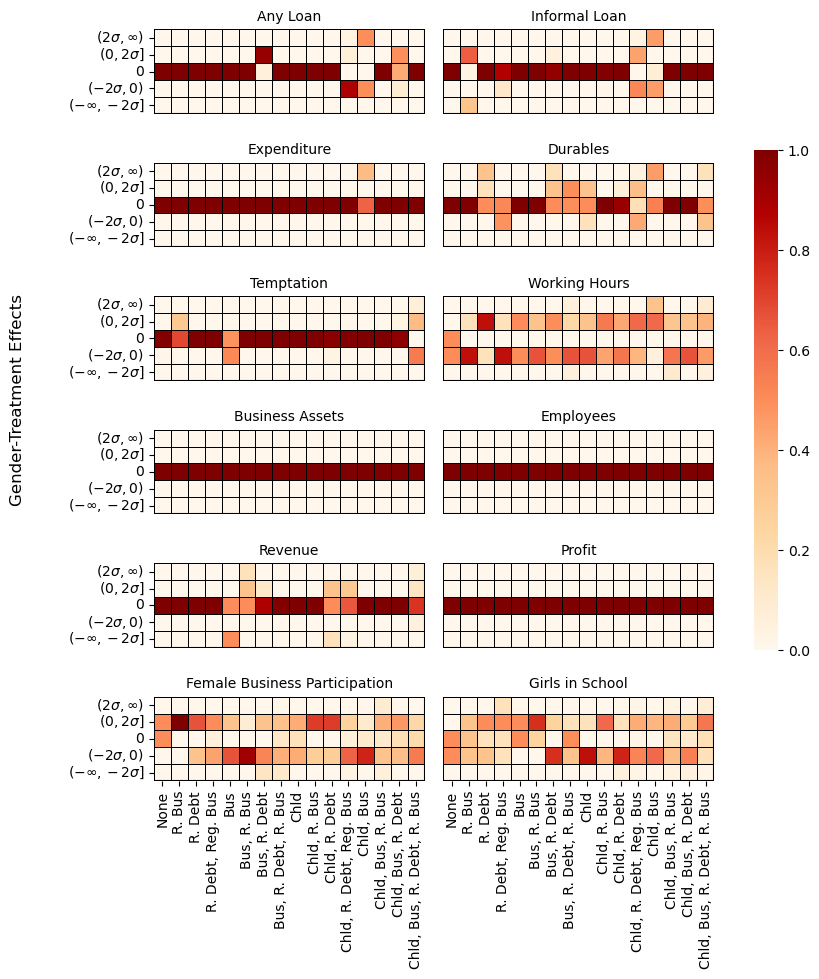

In [13]:
lambda_str="1.50e-6"
plot_gender_effects = True

fig = plt.figure(figsize=(8, 10)) #layout=None, facecolor='lightblue')

profile_subset = False

if profile_subset:
    gs = fig.add_gridspec(nrows=6, ncols=4, # left=0.2, # right=0.75,
                      hspace=0.3, wspace=0.05)
    profiles_to_consider = [0, 5, 6, 8, 12]
else:
    gs = fig.add_gridspec(nrows=6, ncols=4, left=0.2, # right=0.75,
                      hspace=0.3, wspace=0.15)
    profiles_to_consider = list(range(0, 16))
considered_labels = [profile_labels_on[x] for x in profiles_to_consider]


arg_sorted_outcomes = [0, 1, 6, 4, 5, 3, 11, 9, 8, 7, 2, 10]


cbar_ax = fig.add_axes([.95, .25, .03, .5])

for idx in range(12):
    i = idx // 2
    j = (idx % 2) * 2

    
    outcome_idx = arg_sorted_outcomes[idx]

    if plot_gender_effects:
        ax_ij = fig.add_subplot(gs[i, j:(j+2)])
        res = sns.heatmap(
            gender_counts[outcome_idx],
            cmap="OrRd",
            linewidths=0.5,
            linecolor="black",
            square=True,
            vmin=0,
            vmax=1,
            ax=ax_ij,
            cbar_ax=cbar_ax
        )
    else:
        ax_ij = fig.add_subplot(gs[i, j:(j+2)])
        res = sns.heatmap(
            pooled_counts[outcome_idx][:, profiles_to_consider],
            cmap="OrRd",
            linewidths=0.5,
            linecolor="black",
            square=True,
            vmin=0,
            vmax=1,
            ax=ax_ij,
            cbar_ax=cbar_ax
        )
    res.axhline(y=5, color='black', linewidth=1.5)
    res.axvline(x=16, color='black', linewidth=1.5)
    ax_ij.set_title(outcome_names[outcome_idx], fontsize=10, rotation=0)
    ax_ij.set_yticks([])
    ax_ij.set_xticks([])
    if j == 0:
        ax_ij.set_yticks(np.arange(0, 5) + 0.5, [r"$(2\sigma, \infty)$", r"$(0, 2\sigma]$", "0", "$(-2\sigma, 0)$", "$(-\infty, -2\sigma]$"], rotation=0)
    if i == 5:
        ax_ij.set_xticks(np.arange(0, len(considered_labels))+0.5, considered_labels, rotation=90)


fname = f"../Figures/microfinance/lambda={lambda_str}/treatment_effects_mosaic_2.png"
fig.supylabel("Treatment Effects")
if plot_gender_effects:
    fname = f"../Figures/microfinance/lambda={lambda_str}/gender/treatment_effects_mosaic_gender_2.png"
    fig.supylabel("Gender-Treatment Effects")

if profile_subset:
    fname = fname[:-4] + "_subset.png"

# print(fname)
    
plt.savefig(fname, dpi=300, bbox_inches="tight")

plt.show()

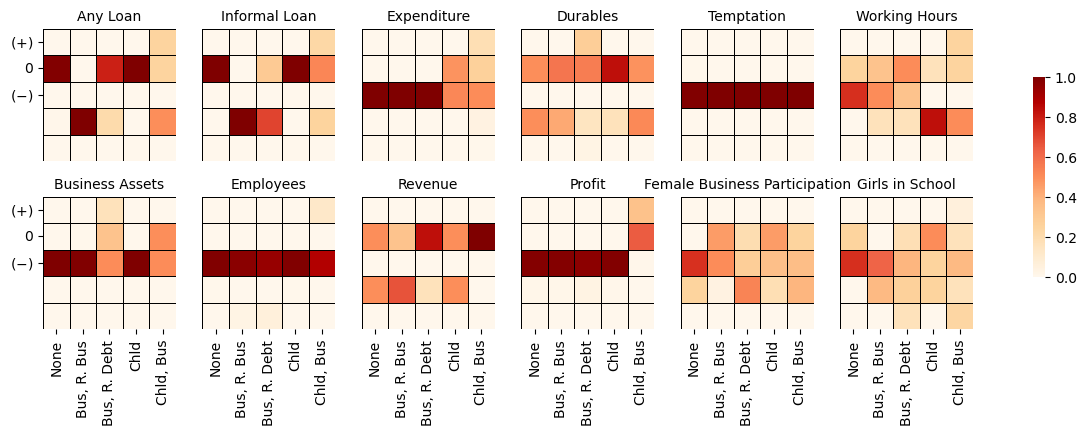

In [15]:
fig = plt.figure(figsize=(12, 4)) #layout=None, facecolor='lightblue')
gs = fig.add_gridspec(nrows=2, ncols=6)

profiles_to_consider = [0, 5, 6, 8, 12]
considered_labels = [profile_labels_on[x] for x in profiles_to_consider]

# considered_labels = [
#     "No children, no experience, thin credit, thin market",
#     "No children, no experience, thin credit, thin market",
#     "No children, no experience, thin credit, thin market",
#     "No children, no experience, thin credit, thin market",
#     "No children, no experience, thin credit, thin market"
# ]


cbar_ax = fig.add_axes([.95, .25, .01, .5])

arg_sorted_outcomes = [0, 1, 6, 4, 5, 3, 11, 9, 8, 7, 2, 10]

for idx in range(12):
    i = idx // 6
    j = (idx % 6)

    outcome_idx = arg_sorted_outcomes[idx]
    
    ax_ij = fig.add_subplot(gs[i, j])
    sns.heatmap(
        pooled_counts[outcome_idx][:, profiles_to_consider],
        cmap="OrRd",
        linewidths=0.5,
        linecolor="black",
        square=True,
        vmin=0,
        vmax=1,
        ax=ax_ij,
        cbar_ax=cbar_ax
    )
    
    ax_ij.set_title(outcome_names[outcome_idx], fontsize=10, rotation=0)
    ax_ij.set_yticks([])
    ax_ij.set_xticks([])
    if j == 0:
        ax_ij.set_yticks(np.arange(0, 3) + 0.5, [r"($+$)", "0", "($-$)"], rotation=0)
    if i == 1:
        ax_ij.set_xticks(np.arange(0, len(considered_labels))+0.5, considered_labels, rotation=90)


fname = f"../Figures/microfinance/lambda={lambda_str}/treatment_effects_mosaic_subset.png"
# fig.supylabel("Treatment Effects")
# print(fname)
    
# plt.savefig(fname, dpi=300, bbox_inches="tight")

plt.show()

# Error estimation plot
Useful for deciding an epsilon to prune at

Outcome is durables_exp_mo_2
Total of 1943 models
Best model loss 0.003375858475570954 and epsilon 0.0010785785763281958


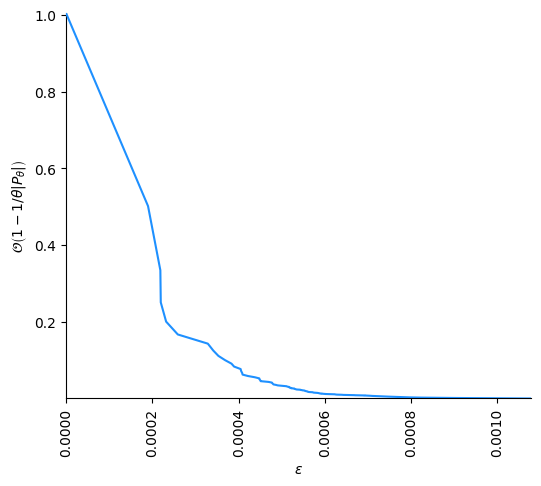

In [ ]:
suffix_possibilities = [
    "",
    "_trt_edu_gen", "_trt_edu", "_trt_gen", "_trt",
    "_edu_gen", "_edu",
    "_gen"
]
selected_suffix_idx = [0, 1, 2, 3, 4, 5, 6, 7]
selected_suffixes = [suffix_possibilities[idx] for idx in selected_suffix_idx]

lambda_str = "_2.00e-06"

for outcome_col_id in range(12, 23):

    if outcome_col_id != 18:
        continue

    outcome_col = cols[outcome_col_id]    
    results_subdir = results_dir + outcome_col + "/"
    pkl_prefix = results_subdir + outcome_col
    print(f"Outcome is {outcome_col}")

    # Read files
    # q0_all = []
    eps_all = []
    R_set_all = []
    R_profiles_all = []
    for suffix in selected_suffixes:
        outcome_fname = results_subdir + outcome_col + suffix + lambda_str + ".pkl"
        # outcome_fname = results_subdir + outcome_col + suffix + "_te.pkl"
        
        with open(outcome_fname, "rb") as f:
            res_dict = pickle.load(f)
        
        # reg = res_dict["reg"]
        # q = res_dict["q"]
        # q0_all.append(res_dict["q0"])
        eps_all.append(res_dict["eps"])
        # H = res_dict["H"]
        R_set_all.append(res_dict["R_set"])
        R_profiles_all.append(res_dict["R_profiles"])

    
    model_losses = []
    suffix_loss_max = []
    for R_set, R_profiles in zip(R_set_all, R_profiles_all):
    # for R_item in R_list_all:
        this_max = -np.inf
        for r, model_r in enumerate(R_set):
            loss_r = 0
            for k, prof_k_id in enumerate(model_r):
                loss_r += R_profiles[k].loss[prof_k_id]
                # loss_r += R_profiles[k][prof_k_id][1]
            model_losses.append(loss_r)
            this_max = max(this_max, loss_r)
        suffix_loss_max.append(this_max)

    print(f"Total of {len(model_losses)} models")
    
    best_loss = np.min(model_losses)
    worst_loss = np.max(model_losses)
    eps = (worst_loss - best_loss) / best_loss
    
    print(f"Best model loss {best_loss} and epsilon {eps}")
    
    # print(f"Smallest model {np.min(model_sizes)}, largest model {np.max(model_sizes)}")
    
    sorted_losses = np.sort(model_losses)
    sorted_epsilon = sorted_losses / best_loss - 1
    
    num_models = np.arange(0, len(model_losses))+1
    model_errors = np.exp(-sorted_losses) * num_models

    #
    # Plot
    #
    fig, ax = plt.subplots(figsize=(6,5))
    
    ax.spines[['right', 'top']].set_visible(False)
    plt.xticks(rotation=90)

    errors_factor = 1 / model_errors
    
    ax.plot(sorted_epsilon, errors_factor,
            color="dodgerblue",
           zorder=3.1)
    
    ax.set_xlabel(r"$\epsilon$")
    ax.set_ylabel(r"$\mathcal{O} \left( 1 - 1 / \theta |P_{\theta}| \right)$", rotation=90)

    
    # ax.set_yticks([1, 100, 200, 300, 400, 500])
    
    ax.set_xlim(0, np.max(sorted_epsilon))
    ax.set_ylim(np.min(errors_factor), np.max(errors_factor))
    
    # plt.savefig(f"../Figures/microfinance/est_error/{outcome_col}_est_error.png", dpi=300, bbox_inches="tight")
    plt.show()
    

# plt.show()

In [ ]:
for outcome_col_id in range(14, 26):
    # print(cols[outcome_col_id])

    if outcome_col_id != 14:
        continue

    suffix = "_trt_gen"
    
    outcome_col = cols[outcome_col_id]
    outcome_fname = results_dir + outcome_col + "/" + outcome_col + suffix + ".pkl"
    # outcome_fname = results_dir + outcome_col + "/" + outcome_col + "_pruned.pkl"
    # print(outcome_fname)
    
    with open(outcome_fname, "rb") as f:
        res_dict = pickle.load(f)
    
    reg = res_dict["reg"]
    q = res_dict["q"]
    # q0 = res_dict["q0"]
    eps = res_dict["eps"]
    # H = res_dict["H"]
    R_set = res_dict["R_set"]
    R_profiles = res_dict["R_profiles"]

    # print(outcome_col_id, outcome_col, reg, q, eps, len(R_set))
    print(q, len(R_set))

    # break

0.0034016 655


In [ ]:
R_set = find_feasible_combinations(R_profiles, 0.003105, np.inf, sorted=True)
print(len(R_set))

24


## Do the pruning to smaller epsilon

In [ ]:
outcome_col_id = 25
outcome_col = cols[outcome_col_id]
print(outcome_col)

results_subdir = results_dir + outcome_col + "/"
pkl_prefix = results_subdir + outcome_col

suffix_possibilities = [
    "",
    "_trt_edu_gen", "_trt_edu", "_trt_gen", "_trt",
    "_edu_gen", "_edu",
    "_gen"
]

lambda_str = "_1.50e-06"


reg_all = []
q0_all = []
eps_all = []
R_set_all = []
R_profiles_all = []

selected_suffix_idx = [0, 1, 2, 3, 4, 5, 6, 7]
selected_suffixes = [suffix_possibilities[idx] for idx in selected_suffix_idx]

for suffix in selected_suffixes:
    outcome_fname = results_subdir + outcome_col + suffix + lambda_str + ".pkl"
    
    with open(outcome_fname, "rb") as f:
        res_dict = pickle.load(f)
    
    reg_all.append(res_dict["reg"])
    # q = res_dict["q"]
    q0_all.append(res_dict["q0"])
    eps_all.append(res_dict["eps"])
    # H = res_dict["H"]
    R_set_all.append(res_dict["R_set"])
    R_profiles_all.append(res_dict["R_profiles"])

    print(f"Suffix: {suffix}\t min q: {q0_all[-1]}\t max q: {res_dict['q']}\t num models: {len(res_dict['R_set'])}")


model_losses = []
for R_set, R_profiles in zip(R_set_all, R_profiles_all):
    for r, model_r in enumerate(R_set):
        loss_r = 0
        for k, prof_k_id in enumerate(model_r):
            loss_r += R_profiles[k].loss[prof_k_id]
        model_losses.append(loss_r)
print(f"Total models: {len(model_losses)}")


best_loss = np.min(model_losses)
worst_loss = np.max(model_losses)

eps_original = worst_loss / best_loss - 1

bizassets_2
Suffix: 	 min q: -inf	 max q: 0.00276	 num models: 0
Suffix: _trt_edu_gen	 min q: -inf	 max q: 0.00276	 num models: 0
Suffix: _trt_edu	 min q: -inf	 max q: 0.00276	 num models: 0
Suffix: _trt_gen	 min q: -inf	 max q: 0.00276	 num models: 0
Suffix: _trt	 min q: -inf	 max q: 0.00276	 num models: 0
Suffix: _edu_gen	 min q: -inf	 max q: 0.00276	 num models: 0
Suffix: _edu	 min q: 0.0027581486095173548	 max q: 0.00276	 num models: 1554
Suffix: _gen	 min q: -inf	 max q: 0.00276	 num models: 0
Total models: 1554


In [ ]:
model_losses = []
model_sizes = []
model_mses = []

for r_set in R_set_all[0]:
    loss_r = 0
    size_r = 0
    
    for profile, model_prof in enumerate(r_set):
        sigma_r_prof = R_profiles_all[0][profile].sigma[model_prof]
        loss_r_prof = R_profiles_all[0][profile].loss[model_prof]
        size_r_prof = R_profiles_all[0][profile].pools[model_prof]

        loss_r += loss_r_prof
        # size_r += size_r_prof
        if sigma_r_prof is None and loss_r_prof == 0:
            pass
        else:
            size_r += size_r_prof
    

    reg = 1e-5

    mse_r = loss_r - reg * size_r
    model_losses.append(loss_r)
    model_sizes.append(size_r)
    model_mses.append(mse_r)

model_losses = np.array(model_losses)
model_sizes = np.array(model_sizes)
model_mses = np.array(model_mses)

In [ ]:
eps = (np.max(model_losses) - np.min(model_losses)) / np.min(model_losses)
H_max = np.max(model_losses) / reg
H_max

358.99984385952916

In [ ]:
np.min(model_mses), np.max(model_mses)

(0.002248748972046507, 0.002296820526899772)

In [ ]:
np.min(model_losses), np.max(model_losses)

(0.003575776107727191, 0.003589998438595292)

In [ ]:
np.min(model_sizes)*reg, np.max(model_sizes)*reg

(0.00128, 0.00134)

In [ ]:
desired_epsilon = 5e-4
loss_threshold = best_loss * (1 + desired_epsilon)

R_set_pruned = []
q_pruned = []
q0_pruned = []
model_losses_pruned = []
for idx, R_set in enumerate(R_set_all):
    R_set_pruned_i = []
    q_pruned_i = -np.inf
    q0_pruned_i = np.inf
    R_profiles = R_profiles_all[idx]
    for r, model_r in enumerate(R_set):
        loss_r = 0
        for k, prof_k_id in enumerate(model_r):
            loss_r += R_profiles[k].loss[prof_k_id]
        if loss_r <= loss_threshold:
            R_set_pruned_i.append(model_r)
            q_pruned_i = max(q_pruned_i, loss_r)
            q0_pruned_i = max(q0_pruned_i, loss_r)
            model_losses_pruned.append(loss_r)
    R_set_pruned.append(R_set_pruned_i)
    q_pruned.append(q_pruned_i)
    q0_pruned.append(q0_pruned_i)

eps_new = np.max(model_losses_pruned) / np.min(model_losses_pruned) - 1


print(f"Original size = {len(model_losses)}. After pruning = {len(model_losses_pruned)}")
print(f"Origial eps = {eps_original}. After pruning = {eps_new}")


for idx, suffix in enumerate(selected_suffixes):
    pruned_outcome_fname = results_subdir + outcome_col + suffix + lambda_str + "_pruned.pkl"

    res_dict = {
        "reg": reg_all[idx],
        "q": q_pruned[idx],
        "q0": q0_pruned[idx],
        "eps": eps_new,
        "H": np.inf,
        "R_set": R_set_pruned[idx],
        "R_profiles": R_profiles_all[idx]
    }
    
    with open(pruned_outcome_fname, "wb") as f:
        pickle.dump(res_dict, f, pickle.HIGHEST_PROTOCOL)

Original size = 1554. After pruning = 279
Origial eps = 0.0006710948552837159. After pruning = 0.000499976042783068
